In [1]:
# load both dataframes
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

original_df = pd.read_csv("./spreadsheets/reflacx_clinical.csv")
original_clinical_cols = [
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
]
chexpert_label_cols = [col for col in original_df if col.endswith("chexpert")]


In [2]:
identified_keywords = {
    "pulmonary consolidation": {
        "boolean": [
            "area of white lung on x-ray",
            "bronchial breath sounds",
            "impaired percussion note",
            "increased vocal fremitus",
            "increased vocal resonance",
            "lower pao2 than calculated in the alveolar gas equation",
            "possible crackles",
            "possible presence of a pleural rub",
            "reduced expansion of the thorax on inspiration",
        ],
        "numerical": [],
    },
    "pleural abnormality": {
        "boolean": [
            "bone fractures",
            "heart failure",
            "hiatal hernia",
            "interstitial lung disease",
            "plaques",
            "pleural effusions",
            "pleural thickening",
            "pneumonia",
            "pneumothorax",
            "pulmonary tuberculosis",
        ],
        "numerical": [],
    },
    "enlarged cardiac silhouette": {
        "boolean": [
            "anxiety",
            "back pain",
            "cardiac tamponade",
            "decreased alertness",
            "diaphoresis",
            "distant heart sounds",
            "distension of the jugular vein",
            "dry cough",
            "electrical alternans on ekg",
            "electrical alternans on holter monitor",
            "fatigue",
            "fever",
            "fluid around the heart",
            "friction rub",
            "left precordial pleuritic chest pain",
            "neck pain",
            "pain in the shoulders",
            "palpitations",  # can be heart-rate. (increased heart-rate)
            "pericardial effusion",
            "positional chest pain",
            "pulsus paradoxus",
            "radiation to the trapezius ridge",
            "relief of pain by bending forward",
            "relief of pain by sitting up",
            "shortness of breath",
            "specific electrocardiogram (ecg) changes",
            "substernal pain",
            "sudden onset of sharp chest pain",
            "weakness",
            "worsening of pain by inspiration",
            "worsening of pain by lying down",
        ],
        "numerical": [
            "systolic blood pressure (mmHg)",  # "low blood pressure"
            "diastolic blood pressure (mmHg)",  # "equilibration of diastolic blood pressures",
        ],
    },
    "pulmonary edema": {
        "boolean": [
            "chest pain",
            "congestive heart failure",
            "coughing",
            "dyspnea",
            "frothy sputum",
            "heart valve dysfunction",
            "hypertensive crisis",
            "hypoxemia",
            "impaired gas exchange",
            "impaired left ventricular function",
            "increased microvascular permeability",
            "pericardial tamponade",
            "respiratory failure",
            "volume overload",
            "wheezing",
        ],
        "numerical": [],
    },
    "atelectasis": {
        "boolean": [
            "anesthesia",
            "asthma",
            "asymptomatic",
            "breathing difficulty",
            "chest pain",
            "chronic obstructive pulmonary disease",
            "cough",
            "cyanosis",
            "fever",
            "pleural effusion",
            "pulmonary tuberculosis",
            "small volume linear shadows",
            "smoking",
        ],
        "numerical": [
            "heart rate (per minute)",  # increased heart-rate.
            "oxygen saturation (%)",  # reduced oxygen saturation.
        ],
    },
}

merged_df = None
auged_features = []
for l in identified_keywords.keys():
    lesion_df = pd.read_csv(f"./whole_dataset/{l}-feature-extension.csv")
    if merged_df is None:
        merged_df = lesion_df 
    else:
        l_features = identified_keywords[l]['boolean'] + identified_keywords[l]['numerical']
        auged_features.extend(l_features)
        for f in l_features:
            merged_df[f] = None
            merged_df[f] = lesion_df[f]

extended_clinical_features = original_clinical_cols + auged_features

In [3]:
from collections import OrderedDict
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics.classification import MultilabelAUROC
import torch

def get_acc_auc(df, input_cols, label_cols, cls):
    cls = cls.fit(
        df[df["split"] == "train"][input_cols],
        df[df["split"] == "train"][label_cols],
    )

    pred = cls.predict(df[df["split"] == "test"][input_cols])

    mla = MultilabelAccuracy(num_labels=len(chexpert_label_cols), average="micro")
    acc = mla(
        torch.tensor(pred),
        (
            torch.tensor(np.array(df[df["split"] == "test"][chexpert_label_cols] > 0))
        ).float(),
    )

    ml_auroc = MultilabelAUROC(num_labels=len(chexpert_label_cols), average="micro")
    auc = ml_auroc(
        torch.tensor(pred),
        (
            torch.tensor(np.array(df[df["split"] == "test"][chexpert_label_cols] > 0))
        ).long(),
    )

    feature_importance_dict = OrderedDict({
        c: i for c, i in zip(input_cols, cls.feature_importances_)
    })
    return feature_importance_dict, acc, auc

def get_important_features(fi):
    return [k for k in fi.keys() if fi[k] > fi['dummy']]
 

In [4]:
for l in chexpert_label_cols:
    original_df[l] = (original_df[l] > 0).astype(float)
    merged_df[l] = (merged_df[l] > 0).astype(float)

In [5]:
# add dummy cols
original_df["dummy"] = np.random.randn(len(original_df))
merged_df["dummy"] = np.random.randn(len(merged_df))

In [6]:
rf_fi, rf_acc, rf_auc = get_acc_auc(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier(),
)
rf_fi, rf_acc, rf_auc

(OrderedDict([('temperature', 0.1500837485313531),
              ('heartrate', 0.16426078745377978),
              ('resprate', 0.08349462076681062),
              ('o2sat', 0.09409282241170674),
              ('sbp', 0.1740802285325742),
              ('dbp', 0.1759902355037901),
              ('dummy', 0.15799755679998526)]),
 tensor(0.9208),
 tensor(0.6314))

In [7]:
tr_fi, tr_acc, tr_auc = get_acc_auc(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    DecisionTreeClassifier(),
)
tr_fi, tr_acc, tr_auc

(OrderedDict([('temperature', 0.20147386067650389),
              ('heartrate', 0.13621778843174043),
              ('resprate', 0.060022580902801465),
              ('o2sat', 0.09531492521637694),
              ('sbp', 0.18113229497927527),
              ('dbp', 0.1809216333348494),
              ('dummy', 0.1449169164584526)]),
 tensor(0.8708),
 tensor(0.6509))

In [8]:
xgb_fi, xgb_acc, xgb_auc = get_acc_auc(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    xgb.XGBClassifier(),
)
xgb_fi, xgb_acc, xgb_auc

(OrderedDict([('temperature', 0.13576597),
              ('heartrate', 0.14527598),
              ('resprate', 0.17520045),
              ('o2sat', 0.14402074),
              ('sbp', 0.13664049),
              ('dbp', 0.1520774),
              ('dummy', 0.11101904)]),
 tensor(0.9024),
 tensor(0.6489))

In [9]:
pd.DataFrame([rf_fi])

,temperature,heartrate,resprate,o2sat,sbp,dbp,dummy
0,0.150084,0.164261,0.083495,0.094093,0.17408,0.17599,0.157998


In [10]:
pd.DataFrame([tr_fi])

,temperature,heartrate,resprate,o2sat,sbp,dbp,dummy
0,0.201474,0.136218,0.060023,0.095315,0.181132,0.180922,0.144917


In [11]:
pd.DataFrame([xgb_fi])

,temperature,heartrate,resprate,o2sat,sbp,dbp,dummy
0,0.135766,0.145276,0.1752,0.144021,0.13664,0.152077,0.111019


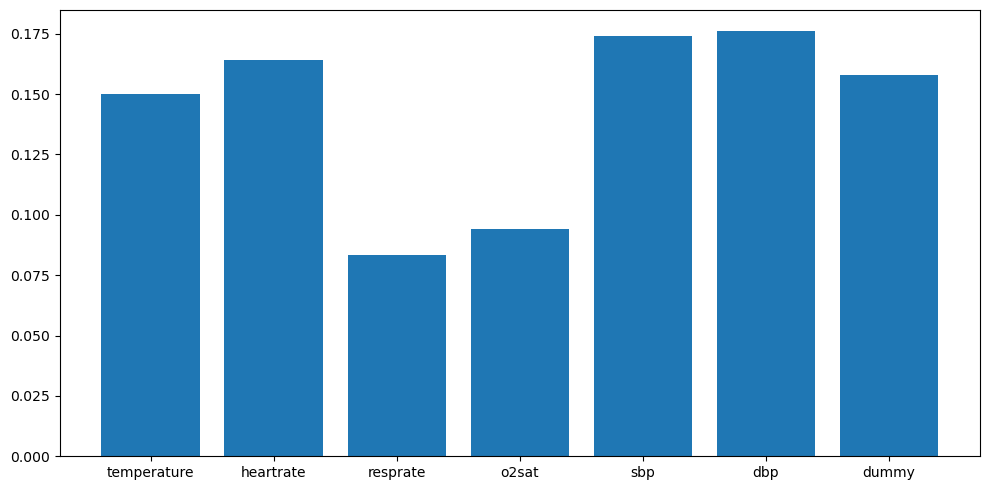

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.bar(
    list(rf_fi.keys()),
    list(rf_fi.values()),
)
plt.tight_layout()
plt.show()

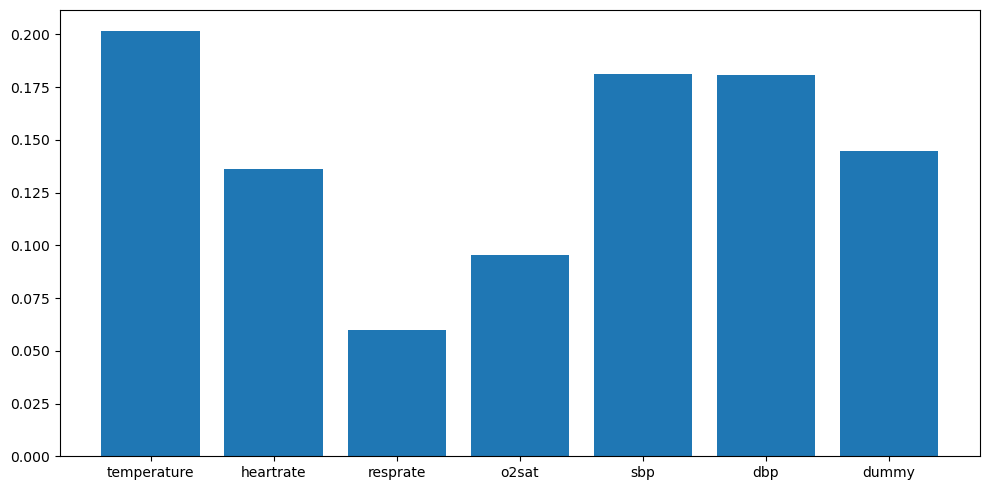

In [13]:
fig = plt.figure(figsize=(10, 5))
plt.bar(
    list(tr_fi.keys()),
    list(tr_fi.values()),
)
plt.tight_layout()
plt.show()


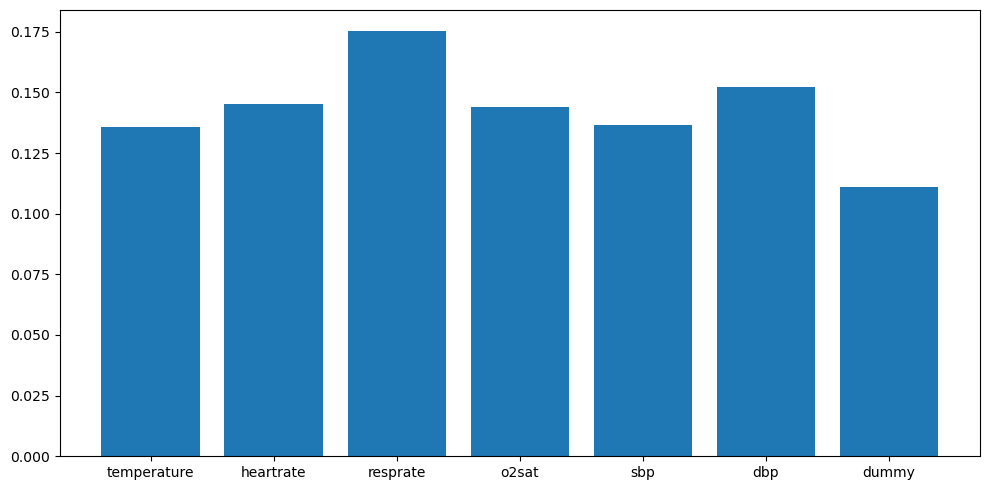

In [14]:
fig = plt.figure(figsize=(10, 5))
plt.bar(
    list(xgb_fi.keys()),
    list(xgb_fi.values()),
)
plt.tight_layout()
plt.show()

In [15]:
get_important_features(rf_fi)

['heartrate', 'sbp', 'dbp']

In [16]:
get_important_features(tr_fi)

['temperature', 'sbp', 'dbp']

In [17]:
get_important_features(xgb_fi)

['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']

In [35]:
min(5, 15)

5

In [57]:
def get_summary(df, input_cols, label_cols, cls, r=5):
    fis = []
    accs = []
    aucs = []

    for _ in range(r):
        fi, acc, auc = get_acc_auc(
            df,
            input_cols,
            label_cols,
            cls,
        )
        fis.append(fi)
        accs.append(acc)
        aucs.append(auc)

    avg_fis = OrderedDict({})
    for k in fis[0].keys():
        avg_fis[k] = np.array([fi_[k] for fi_ in fis]).mean()

    accs = np.array(accs)
    aucs = np.array(aucs)
    important_f = get_important_features(avg_fis)
    
    fi_fig = plt.figure(figsize=(max(10, len(avg_fis)*0.5), 5))
    plt.bar(
        list(avg_fis.keys()),
        list(avg_fis.values()),
    )
    plt.setp(fi_fig.axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

    return {
        "accuracy_mean": accs.mean(),
        "accuracy_std": accs.std(),
        "AUC_mean": aucs.mean(),
        "AUC_std": aucs.std(),
        "fi_df": pd.DataFrame([avg_fis]),
        "#fi>dummy": len(important_f),
        "fi>dummy": important_f,
        "fi_fig": fi_fig,
    }

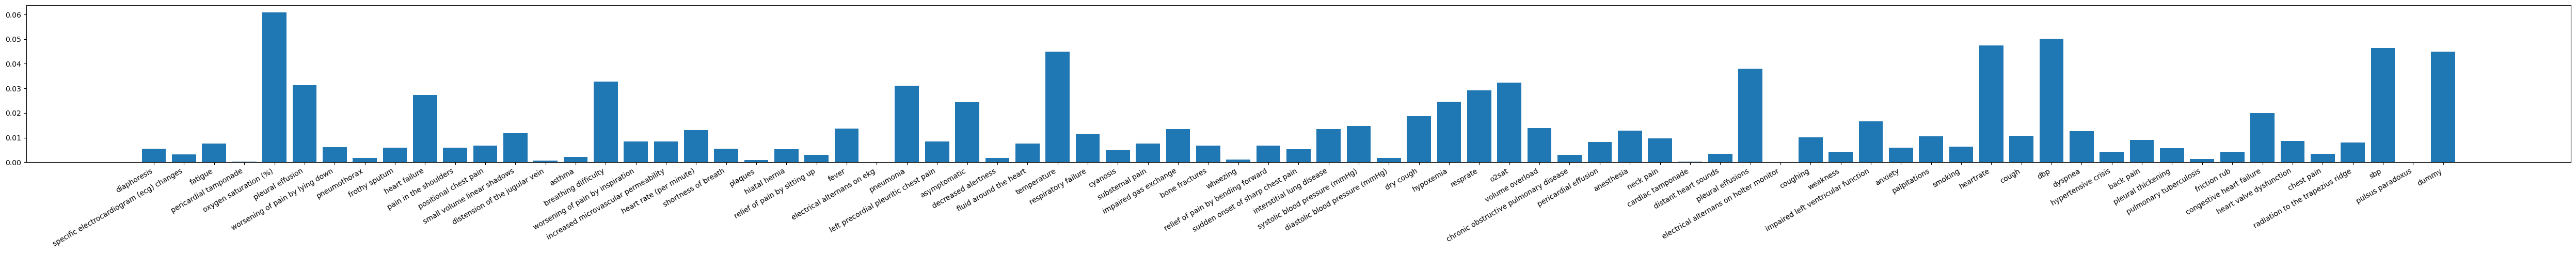

In [55]:
result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier(),
)

In [18]:
aug_rf_fi, aug_rf_acc, aug_rf_auc = get_acc_auc(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier(),
)
aug_rf_fi, aug_rf_acc, aug_rf_auc

(OrderedDict([('diaphoresis', 0.005244794223498527),
              ('specific electrocardiogram (ecg) changes',
               0.003331079113416307),
              ('fatigue', 0.006035779006740289),
              ('pericardial tamponade', 0.0003262849960926313),
              ('oxygen saturation (%)', 0.0573381180469943),
              ('pleural effusion', 0.027732485358440386),
              ('worsening of pain by lying down', 0.006132067490593849),
              ('pneumothorax', 0.001957902119697076),
              ('frothy sputum', 0.006674173392389951),
              ('heart failure', 0.026730017175767274),
              ('pain in the shoulders', 0.006237071251687123),
              ('positional chest pain', 0.007635773230123085),
              ('small volume linear shadows', 0.013032435368807051),
              ('distension of the jugular vein', 0.0009508721407335893),
              ('asthma', 0.002389825945926208),
              ('breathing difficulty', 0.03670504306357455),
    

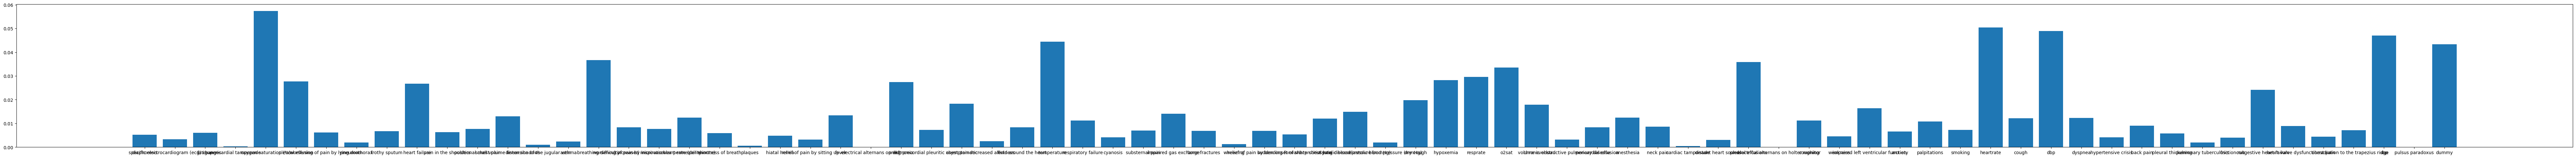

In [19]:
fig = plt.figure(figsize=(80, 5))
plt.bar(
    list(aug_rf_fi.keys()),
    list(aug_rf_fi.values()),
)
plt.tight_layout()
plt.show()

In [20]:
get_important_features(aug_rf_fi)

['oxygen saturation (%)', 'temperature', 'heartrate', 'dbp', 'sbp']

In [21]:
aug_tr_fi, aug_tr_acc, aug_tr_auc = get_acc_auc(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    DecisionTreeClassifier(),
)
aug_tr_fi, aug_tr_acc, aug_tr_auc

(OrderedDict([('diaphoresis', 0.008205544513155085),
              ('specific electrocardiogram (ecg) changes',
               0.005845560602594686),
              ('fatigue', 0.0013700532662331295),
              ('pericardial tamponade', 0.0),
              ('oxygen saturation (%)', 0.18840880486928732),
              ('pleural effusion', 0.005784669346317656),
              ('worsening of pain by lying down', 0.0),
              ('pneumothorax', 0.0038979339841070295),
              ('frothy sputum', 0.0),
              ('heart failure', 0.04565142249783808),
              ('pain in the shoulders', 0.006165239698049083),
              ('positional chest pain', 0.002435650251081119),
              ('small volume linear shadows', 0.009597398777817703),
              ('distension of the jugular vein', 0.0),
              ('asthma', 0.0),
              ('breathing difficulty', 0.0),
              ('worsening of pain by inspiration', 0.0018267376883108395),
              ('increased micr

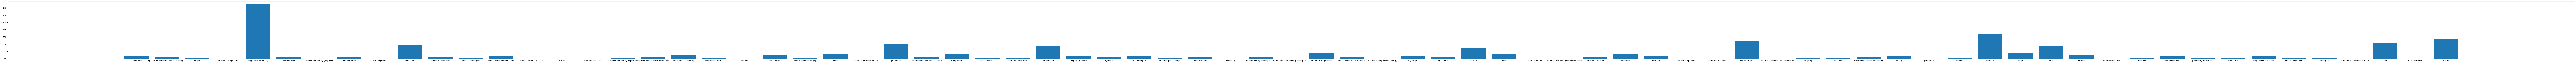

In [22]:
fig = plt.figure(figsize=(200, 5))
plt.bar(
    list(aug_tr_fi.keys()),
    list(aug_tr_fi.values()),
)
plt.tight_layout()
plt.show()

In [23]:
get_important_features(aug_tr_fi)

['oxygen saturation (%)', 'heartrate']

In [24]:
aug_xgb_fi, aug_xgb_acc, aug_xgb_auc = get_acc_auc(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    xgb.XGBClassifier(),
)
aug_xgb_fi, aug_xgb_acc, aug_xgb_auc

(OrderedDict([('diaphoresis', 0.01433707),
              ('specific electrocardiogram (ecg) changes', 0.010063589),
              ('fatigue', 0.006643211),
              ('pericardial tamponade', 0.0),
              ('oxygen saturation (%)', 0.0837648),
              ('pleural effusion', 0.013013463),
              ('worsening of pain by lying down', 0.010106823),
              ('pneumothorax', 0.0),
              ('frothy sputum', 0.015815161),
              ('heart failure', 0.05281458),
              ('pain in the shoulders', 0.014072481),
              ('positional chest pain', 0.010626833),
              ('small volume linear shadows', 0.013775308),
              ('distension of the jugular vein', 0.0),
              ('asthma', 0.009490463),
              ('breathing difficulty', 0.03482878),
              ('worsening of pain by inspiration', 0.007049659),
              ('increased microvascular permeability', 0.014054026),
              ('heart rate (per minute)', 0.012324171),
 

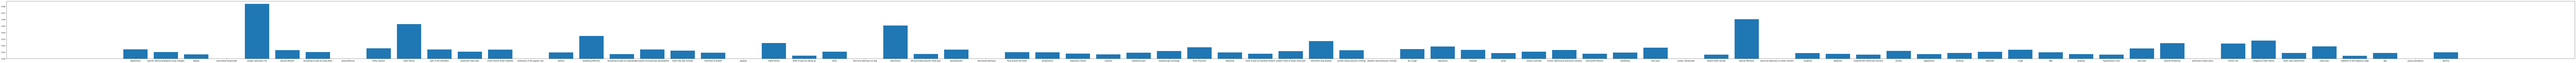

In [25]:
fig = plt.figure(figsize=(200, 5))
plt.bar(
    list(aug_xgb_fi.keys()),
    list(aug_xgb_fi.values()),
)
plt.tight_layout()
plt.show()

In [26]:
get_important_features(aug_xgb_fi)

['diaphoresis',
 'specific electrocardiogram (ecg) changes',
 'oxygen saturation (%)',
 'pleural effusion',
 'worsening of pain by lying down',
 'frothy sputum',
 'heart failure',
 'pain in the shoulders',
 'positional chest pain',
 'small volume linear shadows',
 'breathing difficulty',
 'increased microvascular permeability',
 'heart rate (per minute)',
 'hiatal hernia',
 'fever',
 'pneumonia',
 'asymptomatic',
 'fluid around the heart',
 'temperature',
 'impaired gas exchange',
 'bone fractures',
 'sudden onset of sharp chest pain',
 'interstitial lung disease',
 'systolic blood pressure (mmHg)',
 'dry cough',
 'hypoxemia',
 'resprate',
 'volume overload',
 'chronic obstructive pulmonary disease',
 'neck pain',
 'pleural effusions',
 'anxiety',
 'heartrate',
 'cough',
 'dbp',
 'back pain',
 'pleural thickening',
 'friction rub',
 'congestive heart failure',
 'chest pain']

In [ ]:
dt_result = get_summary(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    DecisionTreeClassifier(),
    r=10,
)
dt_result

In [ ]:
rf_result = get_summary(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier(),
    r=10,
)
rf_result

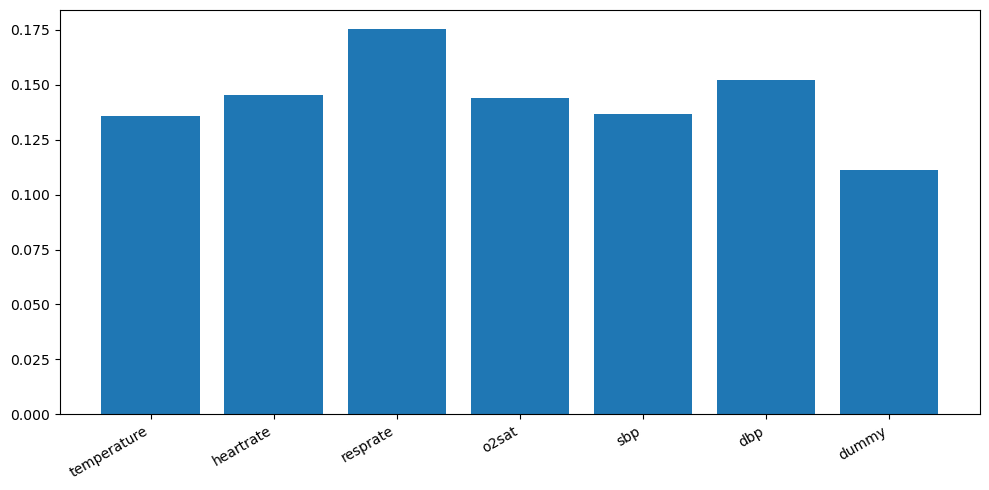

In [58]:
xgb_result = get_summary(
    original_df,
    original_clinical_cols + ["dummy"],
    chexpert_label_cols,
    xgb.XGBClassifier(),
    r=10,
)
xgb_result

In [ ]:
aug_dt_result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    DecisionTreeClassifier(),
)

In [ ]:
aug_rf_result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier(),
)

In [ ]:
aug_rf_result = get_summary(
    merged_df,
    list(set(extended_clinical_features)) + ["dummy"],
    chexpert_label_cols,
    RandomForestClassifier(),
)

In [27]:
# test load whole dataset.